In [1]:
from __future__ import print_function, division
%run ../basics.ipynb

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['show_config']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Loading BokehJS ...

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../data/learning_resources.csv')
display(df.head(2))
tags = pd.read_csv('../data/tags.csv')
display(tags.head(2))
df['tags'] = df['id'].apply(lambda x: (' '.join(tags[tags['id'] == x]['concept_tag'].values.tolist())).strip())
print(df.columns)
print(df.count()/len(df)*100)
df.head(2)

id                      title                                  subtitle  \
0  cs101  Intro to Computer Science  Build a Search Engine & a Social Network   
1  ud257                A/B Testing     Online Experiment Design and Analysis   

                                         description  \
0  In this introduction to computer programming c...   
1  This course will cover the design and analysis...   

                                   short_description  \
0  Learn key computer science concepts in this in...   
1  This course will cover the design and analysis...   

                                            syllabus  \
0  ###Lesson 1: How to Get Started\n\n- Interview...   
1  ### Lesson 1: Overview of A/B Testing\nThis le...   

                                                 url  \
0  https://www.udacity.com/course/intro-to-comput...   
1  https://www.udacity.com/course/ab-testing--ud2...   

                               slug    difficulty created   ...     available  \
0  intro-to-computer-science--cs101      beginner     NaN   ...           NaN   
1                 ab-testing--ud257  intermediate     NaN   ...           NaN   

  end_date typical_learning_time  rating price new language  format  \
0      NaN               3months     NaN  Free NaN       en    MOOC   
1      NaN               1months     NaN  Free NaN       en    MOOC   

                                             license    venue  
0  Creative Commons Attribution-NonCommercial- No...  Udacity  
1  Creative Commons Attribution-NonCommercial- No...  Udacity  

[2 rows x 22 columns]

id          shortname    concept_tag  \
0  ud257  ab-testing--ud257  video_lecture   
1  ud257  ab-testing--ud257       in_depth   

                                                 url  
0  https://www.udacity.com/course/ab-testing--ud2...  
1  https://www.udacity.com/course/ab-testing--ud2...

Index([u'id', u'title', u'subtitle', u'description', u'short_description',
       u'syllabus', u'url', u'slug', u'difficulty', u'created',
       u'date_modified', u'date_published', u'available', u'end_date',
       u'typical_learning_time', u'rating', u'price', u'new', u'language',
       u'format', u'license', u'venue', u'tags'],
      dtype='object')
id                       100.000000
title                     99.781659
subtitle                  25.545852
description               85.152838
short_description          3.711790
syllabus                  10.043668
url                      100.000000
slug                     100.000000
difficulty                24.235808
created                   44.978166
date_modified              0.000000
date_published            44.978166
available                 44.978166
end_date                   0.000000
typical_learning_time     44.104803
rating                    17.685590
price                     98.689956
new                        0.00

id                      title                                  subtitle  \
0  cs101  Intro to Computer Science  Build a Search Engine & a Social Network   
1  ud257                A/B Testing     Online Experiment Design and Analysis   

                                         description  \
0  In this introduction to computer programming c...   
1  This course will cover the design and analysis...   

                                   short_description  \
0  Learn key computer science concepts in this in...   
1  This course will cover the design and analysis...   

                                            syllabus  \
0  ###Lesson 1: How to Get Started\n\n- Interview...   
1  ### Lesson 1: Overview of A/B Testing\nThis le...   

                                                 url  \
0  https://www.udacity.com/course/intro-to-comput...   
1  https://www.udacity.com/course/ab-testing--ud2...   

                               slug    difficulty created  \
0  intro-to-computer-science--cs101      beginner     NaN   
1                 ab-testing--ud257  intermediate     NaN   

                         ...                          end_date  \
0                        ...                               NaN   
1                        ...                               NaN   

  typical_learning_time rating  price new language format  \
0               3months    NaN   Free NaN       en   MOOC   
1               1months    NaN   Free NaN       en   MOOC   

                                             license    venue  \
0  Creative Commons Attribution-NonCommercial- No...  Udacity   
1  Creative Commons Attribution-NonCommercial- No...  Udacity   

                                                tags  
0  video_lecture project overview computer_scienc...  
1  video_lecture in_depth project data_collection...  

[2 rows x 23 columns]

In [38]:
class CLF(object):
    def __init__(self, n_topics=20, tfidf_max_df=None, tfidf_min_df=None, tag_vec_max_df=None, tag_vec_min_df=None, 
                 ngram_range=None, nmf=True, **kwargs):
        self.n_topics = n_topics
        self.vectorizer = TfidfVectorizer(stop_words='english',
                                          max_df=0.6 if tfidf_max_df is None else tfidf_max_df,
                                          min_df=5 if tfidf_min_df is None else tfidf_min_df,
                                          ngram_range=(1 ,3) if ngram_range is None else ngram_range)
        
        self.tag_vectorizer = CountVectorizer(max_df=.3 if tag_vec_max_df is None else tag_vec_max_df,
                                              min_df=0 if tag_vec_min_df is None else tag_vec_min_df)
        
        self.nmf = NMF(n_components=n_topics, random_state=2016) if nmf else None
        self.clf = None
        self.topic_dict = None
        self.kwargs = kwargs

    def fit(self, X, y, viz=True, *args, **kwargs):
        orig_X = X.copy()
        X = self.prepare_X(X)
        X = self.vectorize_X(X, fit=True, viz=viz)
        if viz:
            try:
                tsne_plot(X, orig_X[[orig_X.columns[0]]], fit=True)
            except:
                print(traceback.format_exc())
        y = self.vectorize_y(y, fit=True)
        self.clf = OneVsRestClassifier(KNeighborsClassifier(**self.kwargs))
        # self.clf = OneVsRestClassifier(LogisticRegression())
        filt = np.array(y.sum(axis=1) > 0).flatten() # don't train on untagged resources
        if sum(filt) != y.shape[0]:
            print('excluding untagged resources for clf training')
            print(y.shape)
            print(filt.shape)
            print(y.shape[0], end=' -> ')
            y = y[filt, :]
            X = X[filt, :]
            print(y.shape[0])
        self.clf.fit(X, y, *args, **kwargs)
        
    def predict(self, X):
        X = self.prepare_X(X)
        X = self.vectorize_X(X, fit=False)
        return self.clf.predict_proba(X)
    
    @staticmethod
    def prepare_X(X):
        if isinstance(X, pd.DataFrame):
            concat_x = pd.Series(index=X.index, data='')
            for i in X.columns:
                concat_x += ' ' + X[i].apply(text_cleanup)
            X = concat_x
        else:
            assert isinstance(X, pd.Series)
        return X
        
    def vectorize_X(self, X, fit=False, viz=False):
        if fit:
            tfidf = self.vectorizer.fit_transform(X.values)
        else:
            tfidf = self.vectorizer.transform(X.values)
        tfidf, words = filter_word_rep(tfidf, self.vectorizer.get_feature_names())
        print('tfidf shape', tfidf.shape)
        # tfidf = (tfidf > 0.).astype('float')
        if self.nmf is not None:
            if fit:
                nmf = self.nmf.fit_transform(tfidf)
                feature_names = words
                n_top_words = 50
                self.topic_dict = dict()
                for topic_idx, topic in enumerate(self.nmf.components_):
                    topic_top_words = [feature_names[i]
                                    for i in topic.argsort()[:-n_top_words - 1:-1]]
                    topic_top_words_vals = sorted(topic.ravel(), reverse=True)[:n_top_words]
                    text_freq = zip(topic_top_words, topic_top_words_vals)
                    if viz:
                        print("v v v v \tTopic #%d\t" % topic_idx, end='v v v v v')
                        wordcloud(text_freq)
                    topic_top_words = ", ".join(topic_top_words)
                    #print(topic_top_words)
                    self.topic_dict[topic_idx] = text_freq
                if viz:
                    viz_nmf_output(nmf)
            else:
                nmf = self.nmf.transform(tfidf)
            print('nmf shape:', nmf.shape)
            return nmf
        else:
            return tfidf.todense()
    
    def plot_word_and_tag_clouds(self, X, y, fit=False, th=0, viz=False):
        X = self.prepare_X(X)
        X = self.vectorize_X(X, fit=fit, viz=viz)
        y = self.vectorize_y(y, fit=fit)
        topic_tags = defaultdict(lambda: np.zeros(y.shape[1]))
        for x_s, y_s in tqdm(zip(X, y)):
            x_s = np.array(x_s).flatten()
            y_s = np.array(y_s).flatten()
            for i, x_i in enumerate(x_s):
                if x_i >= th:
                    topic_tags[i] += (x_i * y_s)
        topic_freq = {key: zip(self.get_tag_names(), val) for key, val in topic_tags.items()}
        for key, text_freq in self.topic_dict.items():
            print('-' * 80)
            wordcloud(text_freq)
            wordcloud(topic_freq[key])
    
    def vectorize_y(self, y, fit=False):
        if fit:
            y = y.fillna(' ')
            y = self.tag_vectorizer.fit_transform(y.values)
            if self.tag_vectorizer.stop_words_:
                print('ignored tags:')
                print(' ,'.join(self.tag_vectorizer.stop_words_))
            print('considered tags: (tag, resources tagged in %)')
            print(' ,'.join(map(str, sorted(zip(self.tag_vectorizer.get_feature_names(), 
                              np.array(y.sum(axis=0)).flatten()/y.shape[0]*100, 
                              np.array(y.sum(axis=0)).flatten()), key=itemgetter(1), reverse=True))))
        else:
            y = self.tag_vectorizer.transform(y.values)
        y = (y > 0).astype('float').todense()
        print('y shape', y.shape)
        return y
    
    def get_tag_names(self):
        return self.tag_vectorizer.get_feature_names()

# resources: 458
tagged resources: 356
tfidf shape (458, 2426)
v v v v 	Topic #0	v v v v v

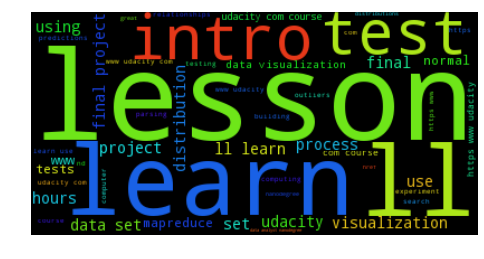

v v v v 	Topic #1	v v v v v

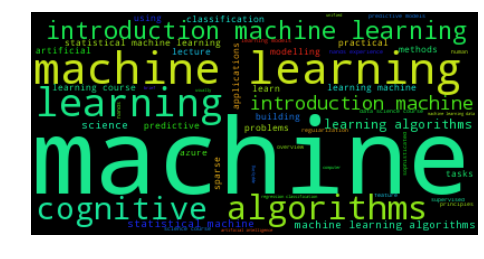

v v v v 	Topic #2	v v v v v

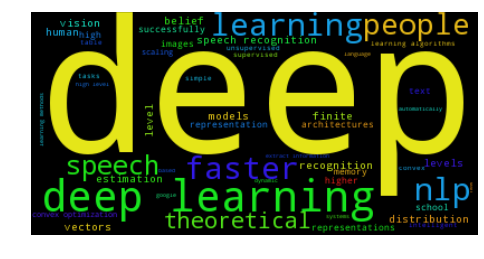

v v v v 	Topic #3	v v v v v

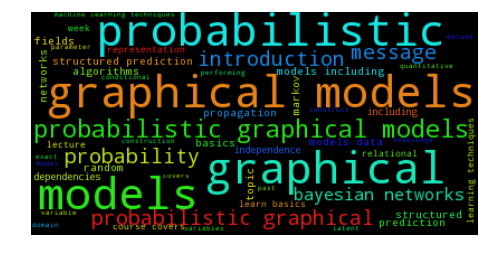

v v v v 	Topic #4	v v v v v

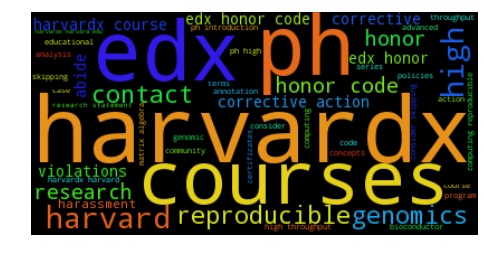

v v v v 	Topic #5	v v v v v

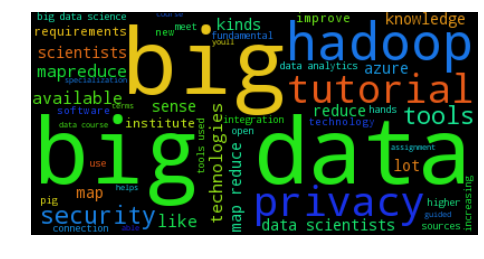

v v v v 	Topic #6	v v v v v

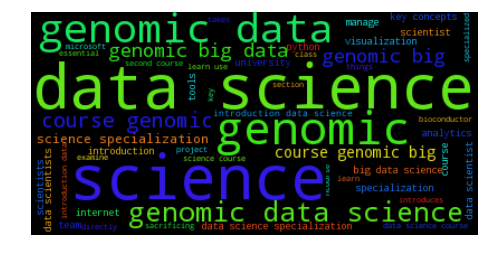

v v v v 	Topic #7	v v v v v

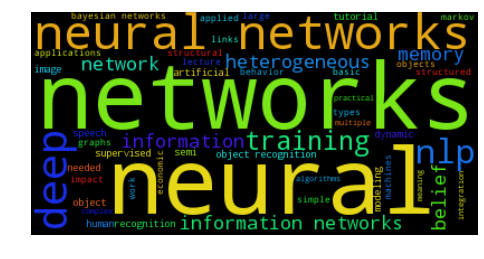

v v v v 	Topic #8	v v v v v

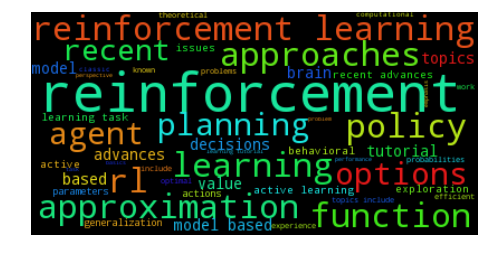

v v v v 	Topic #9	v v v v v

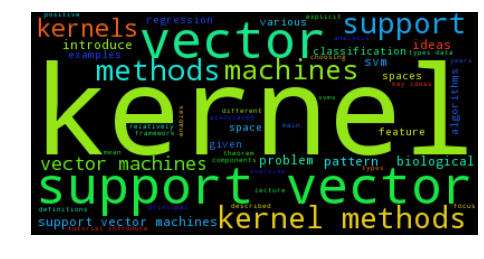

v v v v 	Topic #10	v v v v v

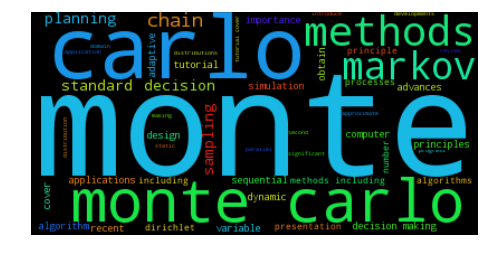

v v v v 	Topic #11	v v v v v

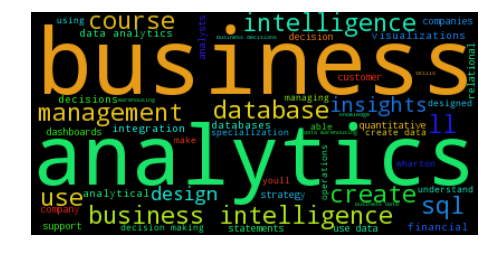

v v v v 	Topic #12	v v v v v

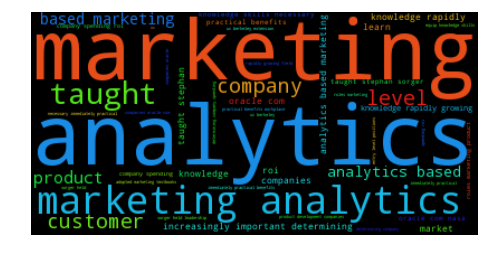

v v v v 	Topic #13	v v v v v

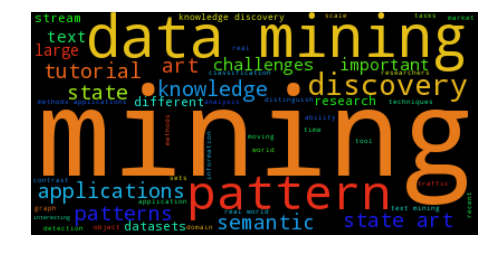

v v v v 	Topic #14	v v v v v

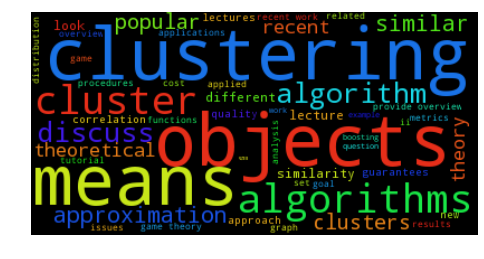

v v v v 	Topic #15	v v v v v

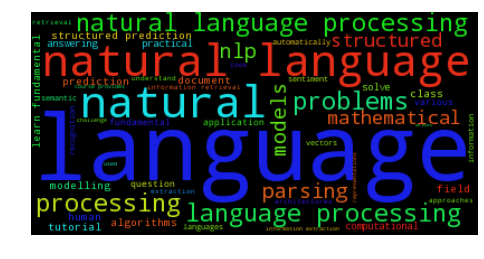

v v v v 	Topic #16	v v v v v

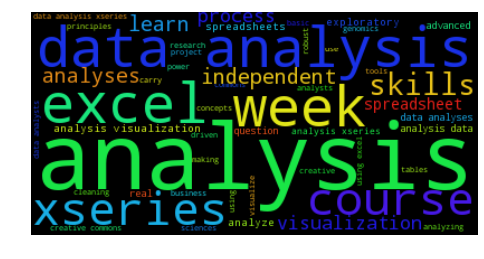

v v v v 	Topic #17	v v v v v

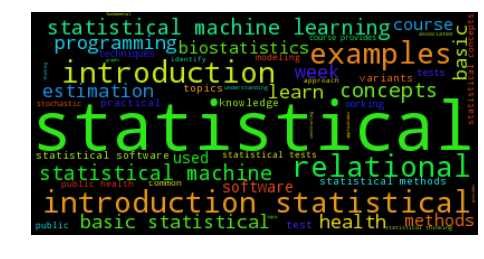

v v v v 	Topic #18	v v v v v

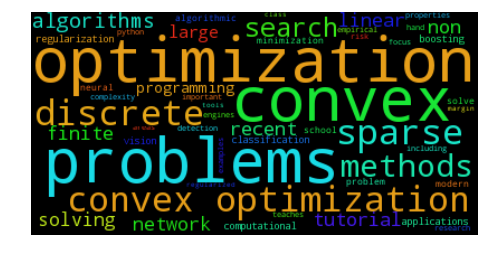

v v v v 	Topic #19	v v v v v

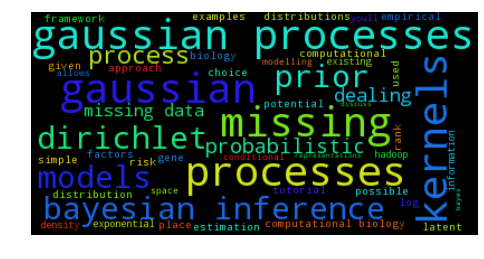

v v v v 	Topic #20	v v v v v

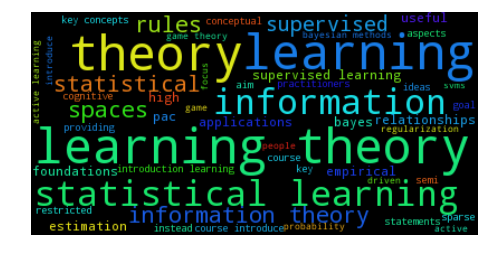

v v v v 	Topic #21	v v v v v

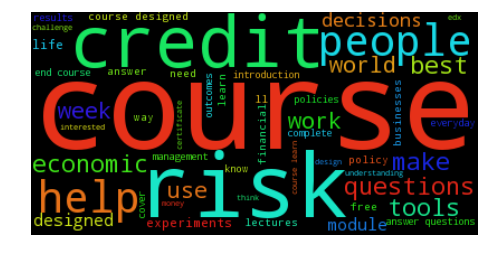

v v v v 	Topic #22	v v v v v

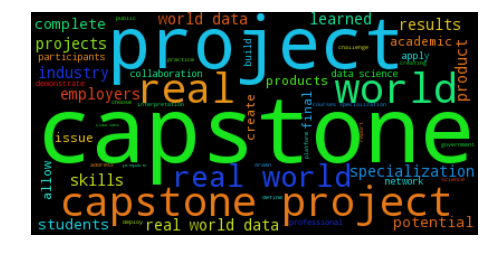

v v v v 	Topic #23	v v v v v

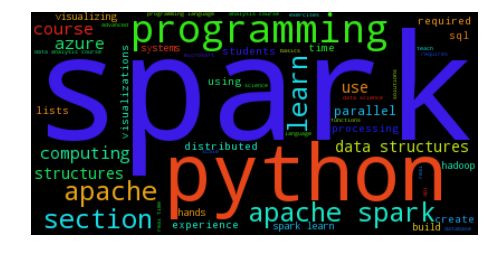

v v v v 	Topic #24	v v v v v

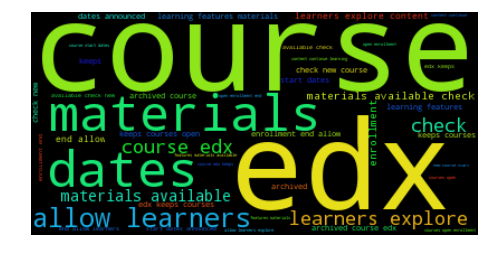

v v v v 	Topic #25	v v v v v

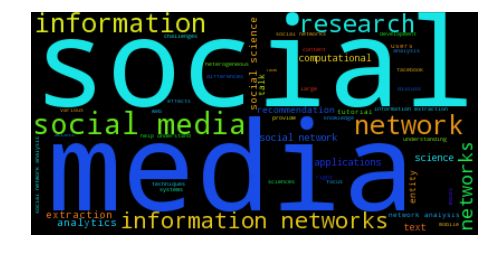

v v v v 	Topic #26	v v v v v

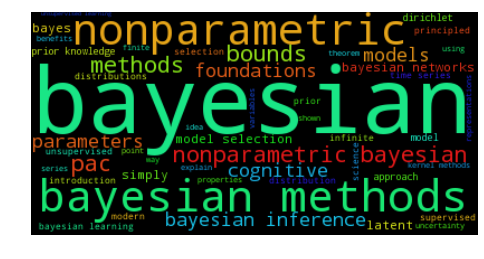

v v v v 	Topic #27	v v v v v

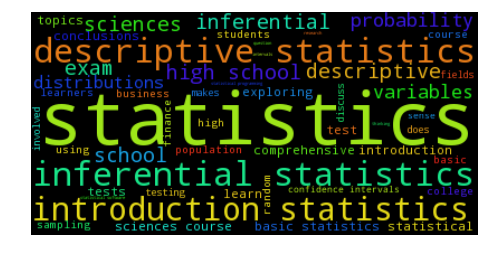

v v v v 	Topic #28	v v v v v

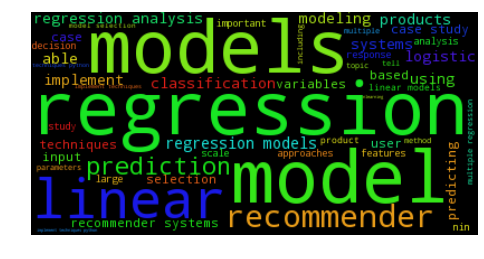

v v v v 	Topic #29	v v v v v

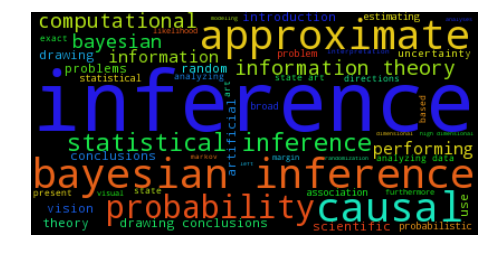

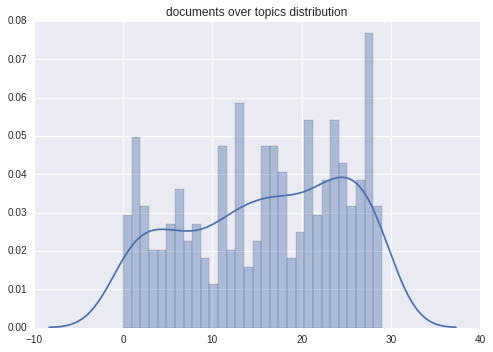

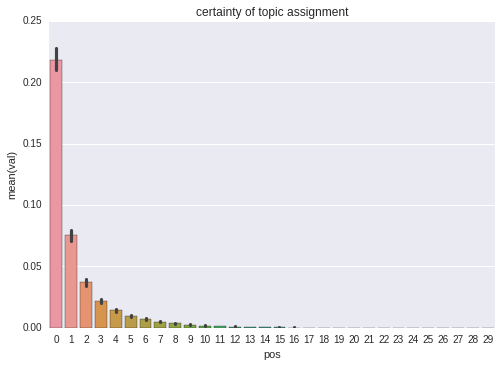

nmf shape: (458, 30)
458


ignored tags:
classification ,programming_tool ,graph_database ,ensemble_learning ,engineering ,topic_model ,image_data ,education ,ethics ,information_retrieval ,fmri ,mooc ,gis ,nosql ,dimensionality_reduction ,mathematics ,html ,galaxy ,mobile_devices ,streaming_data ,xml ,biology ,supervised_learning ,javascript ,time_series_data ,video_lecture ,spark ,data_cleaning ,linear_algebra ,association_rule_learning ,economics ,recommender_system ,optimization ,security ,physics ,history
considered tags: (tag, resources tagged in %)
(u'machine_learning', 28.820960698689959, 132) ,(u'in_depth', 18.5589519650655, 85) ,(u'unsupervised_learning', 11.790393013100436, 54) ,(u'probability_statistics', 11.572052401746726, 53) ,(u'overview', 10.698689956331878, 49) ,(u'project', 9.8253275109170293, 45) ,(u'reinforcement_learning', 8.7336244541484707, 40) ,(u'business_analytics', 7.4235807860262017, 34) ,(u'neural_networks', 6.9868995633187767, 32) ,(u'data_visualization', 5.4585152838427948, 25) ,(

In [25]:
clf = CLF(n_topics=30, tag_vec_min_df=5, nmf=True,
          n_neighbors=3)
print('# resources:', len(df))
print('tagged resources:', (df['tags'].apply(len) > 0).sum())
clf.fit(df[['title', 'subtitle', 'description', 'syllabus']], df['tags'], 
        viz=True)
#clf.plot_word_and_tag_clouds(df[['title', 'subtitle', 'description', 'syllabus']], df['tags'])

In [26]:
y_pred = clf.predict(df[['title', 'subtitle', 'description', 'syllabus']])

tfidf shape (458, 2426)
nmf shape: (458, 30)


In [27]:
pos_th = 0.5
neg_th = 0.5
tags_rec = True
tags_rev = False
recs = list()
revs = list()
y_true = clf.vectorize_y(df['tags'])
tags = np.array(clf.get_tag_names())

print(classification_report(y_true, y_pred > .5, target_names=tags))

for idx, title in enumerate(df['title']):
    y_pred_row = np.array(y_pred[idx, :]).flatten()
    y_true_row = np.array(y_true[idx, :]).flatten()
    recommended_tags = (y_pred_row >= pos_th) & (y_true_row < 0.5)
    recommended_tags = zip(tags[recommended_tags], y_pred_row[recommended_tags])
    
    revise_tags = (y_pred_row <= neg_th) & (y_true_row > 0.5)
    revise_tags = zip(tags[revise_tags], y_pred_row[revise_tags])
    
    if (len(recommended_tags) > 0 and tags_rec) or (len(revise_tags) > 0 and tags_rev):
        print(title)
        df_entry = df.iloc[idx]
        c_id, c_url = df_entry['id'], df_entry['url']
        print(c_id, c_url)
        if len(recommended_tags) > 0 and tags_rec:
            print('  recommended tags:')
            for i, p in sorted(recommended_tags, key=itemgetter(1), reverse=True):
                print('\t', i, '(%.2f' % (p * 100), '% )')
                recs.append((c_id, i, p * 100))
        if len(revise_tags) > 0 and tags_rev:
            print('  revise tags:')
            for i, p in sorted(revise_tags, key=itemgetter(1)):
                print('\t', i, '(%.2f' % ((1. - p) * 100), '% )')
                revs.append((c_id, i, (1. - p) * 100))
        print('-' * 80)

y shape (458, 39)
                               precision    recall  f1-score   support

      artificial_intelligence       0.00      0.00      0.00         7
                     big_data       0.60      0.43      0.50        21
           business_analytics       0.63      0.76      0.69        34
                   case_study       0.50      0.31      0.38        13
                   clustering       0.75      0.50      0.60         6
             computer_science       0.00      0.00      0.00         8
              data_collection       0.71      0.31      0.43        16
             data_integration       0.40      0.14      0.21        14
         data_science_process       0.43      0.33      0.38         9
           data_visualization       0.67      0.40      0.50        25
                    databases       1.00      0.29      0.44         7
                     genetics       0.71      0.62      0.67         8
                 genomic_data       0.71      0.62      0.

In [28]:
rec_df = pd.DataFrame(columns=['id', 'tag', 'probability'], data=recs)
rec_df.to_csv('tag_recommendations.csv', encoding='utf-8', index=False, quoting=QUOTE_ALL)

In [29]:
rev_df = pd.DataFrame(columns=['id', 'tag', 'probability'], data=revs)
rev_df.to_csv('tag_revision.csv', encoding='utf-8', index=False, quoting=QUOTE_ALL)

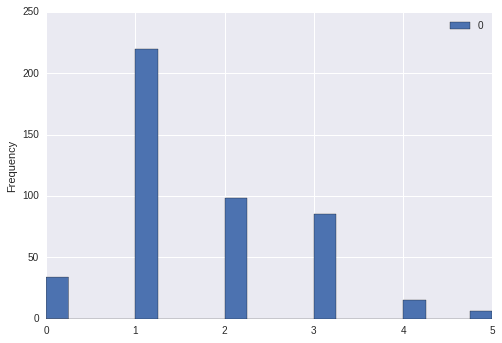

In [30]:
pd.DataFrame((y_pred > 0.5).sum(axis=1)).plot(kind='hist', bins=20)

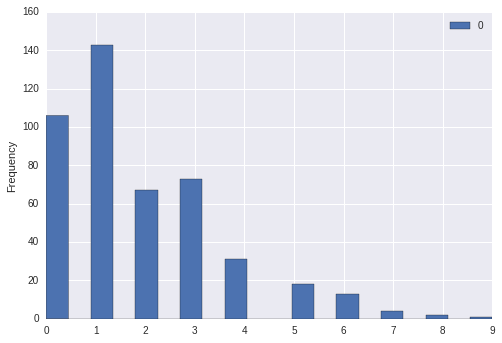

In [31]:
pd.DataFrame((y_true > 0.5).sum(axis=1)).plot(kind='hist', bins=20)

In [32]:
#%run ../basics.ipynb
print('# resources:', len(df))
print('tagged resources:', (df['tags'].apply(len) > 0).sum())
tag_idx = df[df['tags'].apply(len) > 0].index
all_idx = set(df.index)
all_y_pred = list()
all_y_true = list()
tag_names = list()
n_folds = 10

for train_idx, test_idx in tqdm(KFold(len(tag_idx), n_folds=n_folds), total=n_folds):
    test_idx = tag_idx[test_idx]
    train_idx = list(all_idx - set(test_idx))
    train_df = df.loc[train_idx].copy()
    test_df = df.loc[test_idx].copy()
    clf = CLF(n_topics=30, tag_vec_min_df=5, tag_vec_max_df=1., nmf=True, 
              n_neighbors=3)
    clf.fit(train_df[['title', 'subtitle', 'description', 'syllabus']], 
            train_df['tags'], 
            viz=False)
    y_pred = clf.predict(test_df[['title', 'subtitle', 'description', 'syllabus']])
    y_true = clf.vectorize_y(test_df['tags'])
    # print('hamming loss:', hamming_loss(y_true, y_pred))
    all_y_pred.append(y_pred)
    all_y_true.append(y_true)
    tag_names.append(clf.get_tag_names())

  0%|          | 0/10 [00:00<?, ?it/s]

# resources: 458
tagged resources: 356
tfidf shape (422, 2229)
nmf shape: (422, 30)
ignored tags:
graph_data ,information_retrieval ,programming_tool ,graph_database ,ensemble_learning ,engineering ,topic_model ,education ,ethics ,galaxy ,fmri ,gis ,classification ,dimensionality_reduction ,streaming_data ,biology ,time_series_data ,javascript ,supervised_learning ,tabular_data ,mathematics ,spark ,data_cleaning ,linear_algebra ,association_rule_learning ,economics ,recommender_system ,optimization ,security ,physics ,history
considered tags: (tag, resources tagged in %)
(u'machine_learning', 30.09478672985782, 127) ,(u'mooc', 27.014218009478675, 114) ,(u'video_lecture', 26.777251184834121, 113) ,(u'in_depth', 16.587677725118482, 70) ,(u'unsupervised_learning', 12.796208530805686, 54) ,(u'probability_statistics', 9.4786729857819907, 40) ,(u'reinforcement_learning', 9.24170616113744, 39) ,(u'business_analytics', 7.109004739336493, 30) ,(u'neural_networks', 7.109004739336493, 30) ,(u'ove

 10%|█         | 1/10 [00:03<00:27,  3.03s/it]

tfidf shape (36, 2229)
nmf shape: (36, 30)
y shape (36, 39)
tfidf shape (422, 2317)
nmf shape: (422, 30)
ignored tags:
graph_data ,information_retrieval ,programming_tool ,ensemble_learning ,engineering ,topic_model ,image_data ,education ,ethics ,galaxy ,fmri ,gis ,nosql ,dimensionality_reduction ,html ,mobile_devices ,mathematics ,xml ,biology ,supervised_learning ,javascript ,time_series_data ,social_sciences ,tabular_data ,streaming_data ,spark ,data_cleaning ,linear_algebra ,association_rule_learning ,economics ,recommender_system ,optimization ,security ,physics
considered tags: (tag, resources tagged in %)
(u'machine_learning', 30.568720379146917, 129) ,(u'mooc', 27.014218009478675, 114) ,(u'video_lecture', 26.777251184834121, 113) ,(u'in_depth', 14.928909952606634, 63) ,(u'unsupervised_learning', 12.322274881516588, 52) ,(u'probability_statistics', 10.42654028436019, 44) ,(u'overview', 9.9526066350710902, 42) ,(u'reinforcement_learning', 9.4786729857819907, 40) ,(u'project', 8.

 20%|██        | 2/10 [00:06<00:25,  3.13s/it]

tfidf shape (36, 2317)
nmf shape: (36, 30)
y shape (36, 38)
tfidf shape (422, 2274)
nmf shape: (422, 30)
ignored tags:
classification ,programming_tool ,graph_database ,ensemble_learning ,engineering ,topic_model ,image_data ,education ,regression ,information_retrieval ,fmri ,nosql ,dimensionality_reduction ,html ,mobile_devices ,streaming_data ,xml ,biology ,supervised_learning ,javascript ,time_series_data ,social_sciences ,tabular_data ,mathematics ,spark ,data_cleaning ,ethics ,association_rule_learning ,economics ,recommender_system ,optimization ,databases ,security ,physics ,history
considered tags: (tag, resources tagged in %)
(u'machine_learning', 30.33175355450237, 128) ,(u'mooc', 27.014218009478675, 114) ,(u'video_lecture', 27.014218009478675, 114) ,(u'in_depth', 15.165876777251185, 64) ,(u'unsupervised_learning', 12.559241706161137, 53) ,(u'probability_statistics', 10.189573459715639, 43) ,(u'reinforcement_learning', 9.4786729857819907, 40) ,(u'overview', 9.004739336492891

 30%|███       | 3/10 [00:09<00:20,  2.98s/it]

tfidf shape (36, 2274)
nmf shape: (36, 30)
y shape (36, 37)
tfidf shape (422, 2300)
nmf shape: (422, 30)
ignored tags:
classification ,programming_tool ,graph_database ,ensemble_learning ,engineering ,image_data ,education ,ethics ,information_retrieval ,xml ,gis ,nosql ,dimensionality_reduction ,html ,galaxy ,mobile_devices ,mathematics ,biology ,supervised_learning ,javascript ,time_series_data ,tabular_data ,streaming_data ,spark ,data_cleaning ,linear_algebra ,association_rule_learning ,economics ,recommender_system ,optimization ,security ,history
considered tags: (tag, resources tagged in %)
(u'machine_learning', 29.857819905213269, 126) ,(u'mooc', 27.014218009478675, 114) ,(u'video_lecture', 26.777251184834121, 113) ,(u'in_depth', 14.928909952606634, 63) ,(u'unsupervised_learning', 12.796208530805686, 54) ,(u'probability_statistics', 10.189573459715639, 43) ,(u'reinforcement_learning', 9.4786729857819907, 40) ,(u'overview', 9.24170616113744, 39) ,(u'project', 9.0047393364928912,

 40%|████      | 4/10 [00:13<00:19,  3.28s/it]

tfidf shape (36, 2300)
nmf shape: (36, 30)
y shape (36, 40)
tfidf shape (422, 2337)
nmf shape: (422, 30)
ignored tags:
classification ,graph_database ,ensemble_learning ,engineering ,topic_model ,image_data ,education ,ethics ,information_retrieval ,fmri ,gis ,nosql ,dimensionality_reduction ,html ,galaxy ,mobile_devices ,mathematics ,xml ,biology ,supervised_learning ,javascript ,time_series_data ,tabular_data ,streaming_data ,spark ,data_cleaning ,linear_algebra ,association_rule_learning ,economics ,recommender_system ,optimization ,security ,physics ,history
considered tags: (tag, resources tagged in %)
(u'mooc', 34.123222748815166, 144) ,(u'video_lecture', 33.886255924170619, 143) ,(u'machine_learning', 27.014218009478675, 114) ,(u'in_depth', 18.957345971563981, 80) ,(u'probability_statistics', 11.848341232227488, 50) ,(u'overview', 11.374407582938389, 48) ,(u'unsupervised_learning', 11.374407582938389, 48) ,(u'project', 10.42654028436019, 44) ,(u'reinforcement_learning', 8.293838

 50%|█████     | 5/10 [00:16<00:16,  3.37s/it]

tfidf shape (36, 2337)
nmf shape: (36, 30)
y shape (36, 40)
tfidf shape (422, 2315)
nmf shape: (422, 30)
ignored tags:
classification ,programming_tool ,graph_database ,ensemble_learning ,engineering ,topic_model ,image_data ,education ,ethics ,information_retrieval ,fmri ,gis ,nosql ,dimensionality_reduction ,html ,galaxy ,mobile_devices ,mathematics ,artificial_intelligence ,xml ,biology ,javascript ,time_series_data ,social_sciences ,streaming_data ,spark ,data_cleaning ,linear_algebra ,economics ,recommender_system ,optimization ,security ,physics ,history
considered tags: (tag, resources tagged in %)
(u'mooc', 35.545023696682463, 150) ,(u'video_lecture', 35.308056872037916, 149) ,(u'machine_learning', 27.251184834123222, 115) ,(u'in_depth', 20.142180094786731, 85) ,(u'probability_statistics', 12.322274881516588, 52) ,(u'overview', 11.611374407582939, 49) ,(u'project', 10.66350710900474, 45) ,(u'unsupervised_learning', 9.9526066350710902, 42) ,(u'business_analytics', 8.056872037914

 60%|██████    | 6/10 [00:19<00:12,  3.15s/it]

tfidf shape (36, 2315)
nmf shape: (36, 30)
y shape (36, 39)
tfidf shape (423, 2329)
nmf shape: (423, 30)
ignored tags:
classification ,programming_tool ,graph_database ,ensemble_learning ,engineering ,topic_model ,image_data ,education ,ethics ,information_retrieval ,fmri ,gis ,nosql ,dimensionality_reduction ,html ,galaxy ,mobile_devices ,mathematics ,xml ,biology ,supervised_learning ,javascript ,time_series_data ,streaming_data ,spark ,data_cleaning ,linear_algebra ,association_rule_learning ,economics ,recommender_system ,optimization ,security ,physics ,history
considered tags: (tag, resources tagged in %)
(u'mooc', 35.460992907801419, 150) ,(u'video_lecture', 35.224586288416077, 149) ,(u'machine_learning', 26.24113475177305, 111) ,(u'in_depth', 20.094562647754138, 85) ,(u'probability_statistics', 12.056737588652481, 51) ,(u'overview', 11.583924349881796, 49) ,(u'project', 10.638297872340425, 45) ,(u'unsupervised_learning', 10.638297872340425, 45) ,(u'reinforcement_learning', 8.51

 70%|███████   | 7/10 [00:22<00:09,  3.27s/it]

tfidf shape (35, 2329)
nmf shape: (35, 30)
y shape (35, 41)
tfidf shape (423, 2330)
nmf shape: (423, 30)
ignored tags:
classification ,programming_tool ,graph_database ,ensemble_learning ,engineering ,topic_model ,image_data ,education ,ethics ,information_retrieval ,fmri ,gis ,nosql ,dimensionality_reduction ,supervised_learning ,html ,galaxy ,mobile_devices ,mathematics ,xml ,biology ,knowledge_representation ,javascript ,time_series_data ,streaming_data ,spark ,data_cleaning ,linear_algebra ,association_rule_learning ,economics ,recommender_system ,optimization ,physics ,history
considered tags: (tag, resources tagged in %)
(u'mooc', 35.460992907801419, 150) ,(u'video_lecture', 35.224586288416077, 149) ,(u'machine_learning', 26.713947990543733, 113) ,(u'in_depth', 20.094562647754138, 85) ,(u'probability_statistics', 12.293144208037825, 52) ,(u'overview', 11.583924349881796, 49) ,(u'unsupervised_learning', 10.874704491725769, 46) ,(u'project', 10.638297872340425, 45) ,(u'business_ana

 80%|████████  | 8/10 [00:25<00:06,  3.19s/it]

tfidf shape (35, 2330)
nmf shape: (35, 30)
y shape (35, 40)
tfidf shape (423, 2334)
nmf shape: (423, 30)
ignored tags:
classification ,programming_tool ,graph_database ,ensemble_learning ,engineering ,topic_model ,image_data ,education ,ethics ,information_retrieval ,fmri ,gis ,nosql ,xml ,dimensionality_reduction ,html ,galaxy ,mobile_devices ,mathematics ,clustering ,biology ,supervised_learning ,javascript ,time_series_data ,streaming_data ,spark ,data_cleaning ,linear_algebra ,association_rule_learning ,economics ,recommender_system ,optimization ,security ,physics ,history
considered tags: (tag, resources tagged in %)
(u'mooc', 35.460992907801419, 150) ,(u'video_lecture', 35.224586288416077, 149) ,(u'machine_learning', 26.004728132387704, 110) ,(u'in_depth', 20.094562647754138, 85) ,(u'probability_statistics', 11.82033096926714, 50) ,(u'overview', 11.583924349881796, 49) ,(u'unsupervised_learning', 11.347517730496454, 48) ,(u'project', 10.638297872340425, 45) ,(u'business_analytic

 90%|█████████ | 9/10 [00:28<00:02,  2.92s/it]

tfidf shape (35, 2334)
nmf shape: (35, 30)
y shape (35, 40)
tfidf shape (423, 2323)
nmf shape: (423, 30)
ignored tags:
classification ,programming_tool ,graph_database ,ensemble_learning ,engineering ,topic_model ,image_data ,education ,ethics ,information_retrieval ,fmri ,gis ,nosql ,dimensionality_reduction ,html ,galaxy ,mobile_devices ,mathematics ,xml ,biology ,supervised_learning ,javascript ,time_series_data ,social_sciences ,streaming_data ,spark ,data_cleaning ,linear_algebra ,association_rule_learning ,economics ,recommender_system ,optimization ,security ,physics ,history
considered tags: (tag, resources tagged in %)
(u'mooc', 35.460992907801419, 150) ,(u'video_lecture', 35.224586288416077, 149) ,(u'machine_learning', 27.186761229314421, 115) ,(u'in_depth', 20.094562647754138, 85) ,(u'probability_statistics', 12.293144208037825, 52) ,(u'overview', 11.583924349881796, 49) ,(u'project', 10.638297872340425, 45) ,(u'unsupervised_learning', 10.401891252955082, 44) ,(u'business_an

100%|██████████| 10/10 [00:31<00:00,  3.05s/it]

tfidf shape (35, 2323)
nmf shape: (35, 30)
y shape (35, 40)


--------------------------------------------------------------------------------
th: 0.25
                               precision    recall  f1-score   support

      artificial_intelligence       0.00      0.00      0.00         4
                     big_data       0.39      0.57      0.46        21
           business_analytics       0.51      0.85      0.64        34
                   case_study       0.24      0.31      0.27        13
                   clustering       0.50      0.50      0.50         4
             computer_science       0.00      0.00      0.00         8
              data_collection       0.09      0.19      0.12        16
             data_integration       0.11      0.21      0.14        14
         data_science_process       0.20      0.44      0.28         9
           data_visualization       0.18      0.32      0.23        25
                    databases       0.20      0.75      0.32         4
                     genetics       0.55      0.75      0

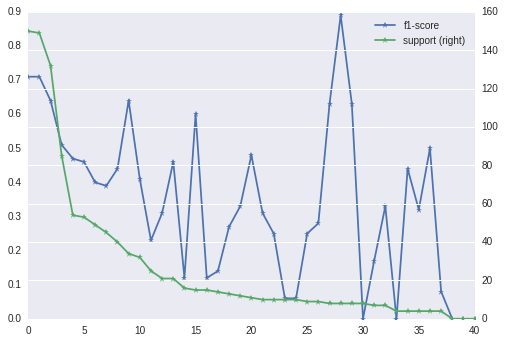

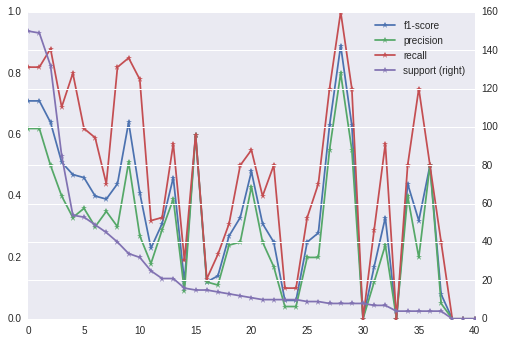

                       class_name  precision  recall  f1-score  support
28  probabilistic_graphical_model       0.80    1.00      0.89        8
0                            mooc       0.62    0.82      0.71      150
1                   video_lecture       0.62    0.82      0.71      149
2                machine_learning       0.50    0.88      0.64      132
9              business_analytics       0.51    0.85      0.64       34
29                       genetics       0.55    0.75      0.63        8
27                   genomic_data       0.55    0.75      0.63        8
15                project_focused       0.60    0.60      0.60       15
3                        in_depth       0.40    0.69      0.51       85
36                     clustering       0.50    0.50      0.50        4
20                 kernel_methods       0.43    0.55      0.48       11
4           unsupervised_learning       0.33    0.80      0.47       54
13                       big_data       0.39    0.57      0.46  

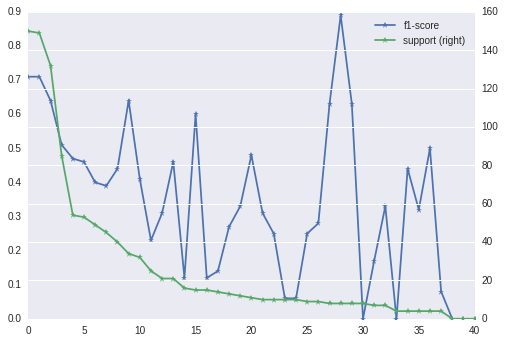

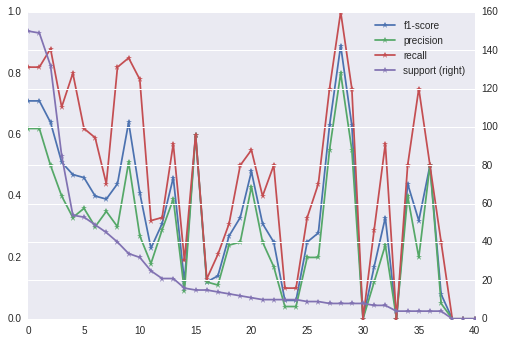

                       class_name  precision  recall  f1-score  support
28  probabilistic_graphical_model       0.80    1.00      0.89        8
0                            mooc       0.62    0.82      0.71      150
1                   video_lecture       0.62    0.82      0.71      149
2                machine_learning       0.50    0.88      0.64      132
9              business_analytics       0.51    0.85      0.64       34
29                       genetics       0.55    0.75      0.63        8
27                   genomic_data       0.55    0.75      0.63        8
15                project_focused       0.60    0.60      0.60       15
3                        in_depth       0.40    0.69      0.51       85
36                     clustering       0.50    0.50      0.50        4
20                 kernel_methods       0.43    0.55      0.48       11
4           unsupervised_learning       0.33    0.80      0.47       54
13                       big_data       0.39    0.57      0.46  

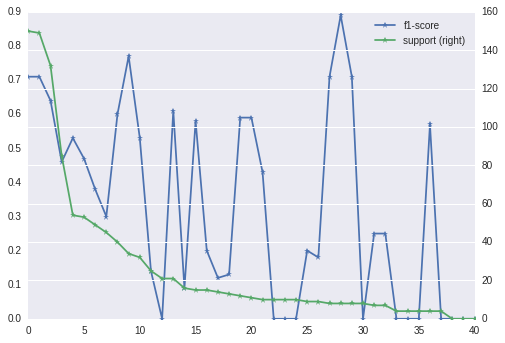

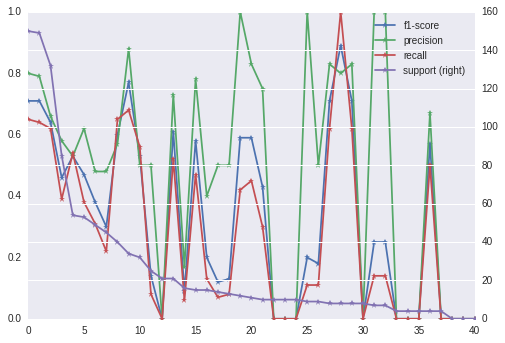

                       class_name  precision  recall  f1-score  support
28  probabilistic_graphical_model       0.80    1.00      0.89        8
9              business_analytics       0.88    0.68      0.77       34
0                            mooc       0.80    0.65      0.71      150
29                       genetics       0.83    0.62      0.71        8
27                   genomic_data       0.83    0.62      0.71        8
1                   video_lecture       0.79    0.64      0.71      149
2                machine_learning       0.66    0.62      0.64      132
13                       big_data       0.73    0.52      0.61       21
8          reinforcement_learning       0.57    0.65      0.60       40
19                         hadoop       1.00    0.42      0.59       12
20                 kernel_methods       0.83    0.45      0.59       11
15                project_focused       0.78    0.47      0.58       15
36                     clustering       0.67    0.50      0.57  

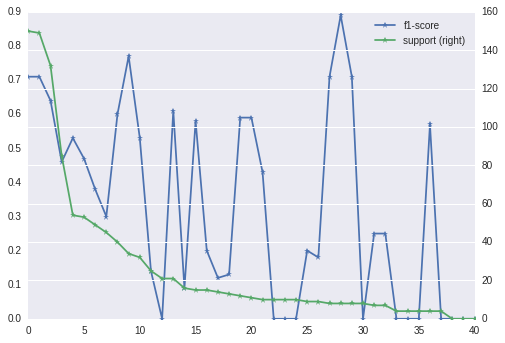

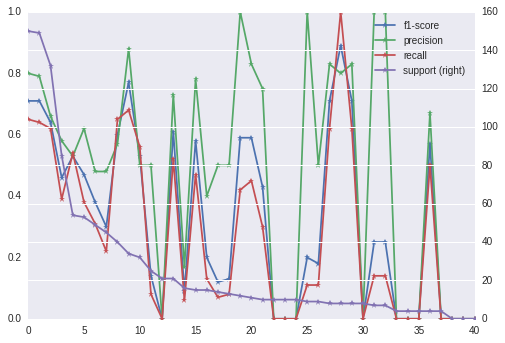

                       class_name  precision  recall  f1-score  support
28  probabilistic_graphical_model       0.80    1.00      0.89        8
9              business_analytics       0.88    0.68      0.77       34
0                            mooc       0.80    0.65      0.71      150
29                       genetics       0.83    0.62      0.71        8
27                   genomic_data       0.83    0.62      0.71        8
1                   video_lecture       0.79    0.64      0.71      149
2                machine_learning       0.66    0.62      0.64      132
13                       big_data       0.73    0.52      0.61       21
8          reinforcement_learning       0.57    0.65      0.60       40
19                         hadoop       1.00    0.42      0.59       12
20                 kernel_methods       0.83    0.45      0.59       11
15                project_focused       0.78    0.47      0.58       15
36                     clustering       0.67    0.50      0.57  

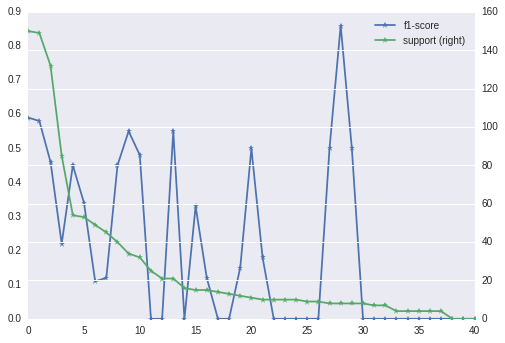

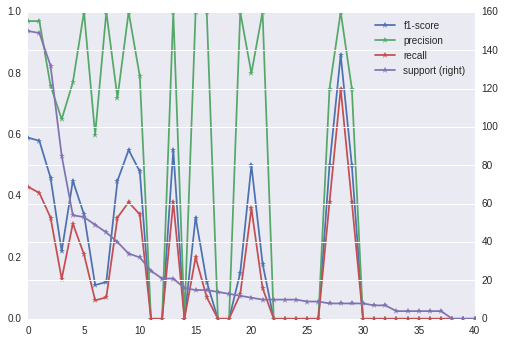

                       class_name  precision  recall  f1-score  support
28  probabilistic_graphical_model       1.00    0.75      0.86        8
0                            mooc       0.97    0.43      0.59      150
1                   video_lecture       0.97    0.41      0.58      149
9              business_analytics       1.00    0.38      0.55       34
13                       big_data       1.00    0.38      0.55       21
29                       genetics       0.75    0.38      0.50        8
27                   genomic_data       0.75    0.38      0.50        8
20                 kernel_methods       0.80    0.36      0.50       11
10                neural_networks       0.79    0.34      0.48       32
2                machine_learning       0.76    0.33      0.46      132
4           unsupervised_learning       0.77    0.31      0.45       54
8          reinforcement_learning       0.72    0.33      0.45       40
5          probability_statistics       1.00    0.21      0.34  

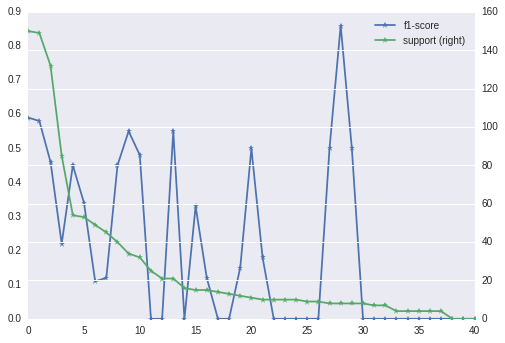

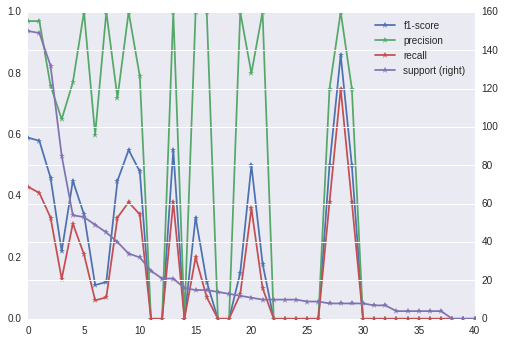

                       class_name  precision  recall  f1-score  support
28  probabilistic_graphical_model       1.00    0.75      0.86        8
0                            mooc       0.97    0.43      0.59      150
1                   video_lecture       0.97    0.41      0.58      149
9              business_analytics       1.00    0.38      0.55       34
13                       big_data       1.00    0.38      0.55       21
29                       genetics       0.75    0.38      0.50        8
27                   genomic_data       0.75    0.38      0.50        8
20                 kernel_methods       0.80    0.36      0.50       11
10                neural_networks       0.79    0.34      0.48       32
2                machine_learning       0.76    0.33      0.46      132
4           unsupervised_learning       0.77    0.31      0.45       54
8          reinforcement_learning       0.72    0.33      0.45       40
5          probability_statistics       1.00    0.21      0.34  

In [33]:
for pred_th in [0.25, 0.3, 0.4, 0.5, 0.75, 0.9]:
    print('-' * 80)
    print('th:', pred_th)
    all_tags = sorted(set([j for i in tag_names for j in i]))
    tmp_all_y_true = list()
    tmp_all_y_pred = list()
    for y_true, y_pred, t_names in zip(all_y_true, all_y_pred, tag_names):
        tmp_y_t = np.zeros((y_true.shape[0], len(all_tags)))
        tmp_y_p = np.zeros((y_pred.shape[0], len(all_tags)))
        sorting = np.array([all_tags.index(i) for i in t_names])
        tmp_y_t[:, sorting] = y_true
        tmp_y_p[:, sorting] = y_pred > pred_th
        tmp_all_y_true.extend([np.array(i).flatten() for i in tmp_y_t])
        tmp_all_y_pred.extend([np.array(i).flatten() for i in tmp_y_p])

    #print('res shape:', all_y_true.shape)
    print(classification_report(np.array(tmp_all_y_true), np.array(tmp_all_y_pred), target_names=all_tags))
    print('hamming loss:', hamming_loss(np.array(tmp_all_y_true), np.array(tmp_all_y_pred)))
    print('LRAP:', label_ranking_average_precision_score(np.array(tmp_all_y_true), np.array(tmp_all_y_pred)))
    clf_rep_df = get_classification_report_df(np.array(tmp_all_y_true), np.array(tmp_all_y_pred), target_names=all_tags)
    clf_rep_df.sort_values(by='support', ascending=False, inplace=True)
    clf_rep_df.index = range(len(clf_rep_df))
    clf_rep_df.plot(y=['f1-score', 'support'], secondary_y=['support'], style='*-')
    plt.show()
    clf_rep_df.plot(y=['f1-score', 'precision', 'recall', 'support'], secondary_y=['support'], style='*-')
    plt.show()
    print(clf_rep_df.sort_values(by='f1-score', ascending=False))

In [41]:
print(pd.unique(df['venue']))

['Udacity' 'Coursera' 'Videolectures.net' 'edX']


In [49]:
print('# resources:', len(df))
print('tagged resources:', (df['tags'].apply(len) > 0).sum())
tag_idx = df[df['tags'].apply(len) > 0].index
all_idx = set(df.index)
test_idx = df[df['venue'] == 'Udacity'].index
train_idx = all_idx - set(test_idx)

print('train tags:', train_df['tags'].apply(lambda x: 0 if x.strip() == '' else len(x.split())).sum())
print('test tags:', test_df['tags'].apply(lambda x: 0 if x.strip() == '' else len(x.split())).sum())

train_df = df.loc[train_idx].copy()
test_df = df.loc[test_idx].copy()
clf = CLF(n_topics=30, tag_vec_min_df=1, tag_vec_max_df=1., nmf=True, 
          n_neighbors=3)
clf.fit(train_df[['title', 'subtitle', 'description', 'syllabus']], 
        train_df['tags'], 
        viz=False)
y_pred_prob = clf.predict(test_df[['title', 'subtitle', 'description', 'syllabus']])
y_true = np.array(clf.vectorize_y(test_df['tags']))
print(y_pred.shape, y_true.shape)

# resources: 458
tagged resources: 356
train tags: 449
test tags: 775
tfidf shape (441, 2287)
nmf shape: (441, 30)
considered tags: (tag, resources tagged in %)
(u'mooc', 30.158730158730158, 133) ,(u'video_lecture', 29.931972789115648, 132) ,(u'machine_learning', 29.251700680272108, 129) ,(u'in_depth', 17.460317460317459, 77) ,(u'unsupervised_learning', 12.244897959183673, 54) ,(u'probability_statistics', 10.204081632653061, 45) ,(u'overview', 9.0702947845804989, 40) ,(u'reinforcement_learning', 8.8435374149659864, 39) ,(u'business_analytics', 7.4829931972789119, 33) ,(u'neural_networks', 7.029478458049887, 31) ,(u'project', 6.8027210884353746, 30) ,(u'big_data', 4.308390022675737, 19) ,(u'data_visualization', 4.308390022675737, 19) ,(u'python', 3.6281179138321997, 16) ,(u'project_focused', 3.4013605442176873, 15) ,(u'graph_analytics', 3.1746031746031744, 14) ,(u'case_study', 2.7210884353741496, 12) ,(u'data_collection', 2.7210884353741496, 12) ,(u'data_integration', 2.4943310657596371

                               precision    recall  f1-score   support

      artificial_intelligence       0.00      0.00      0.00         0
    association_rule_learning       0.00      0.00      0.00         0
                     big_data       1.00      1.00      1.00         2
                      biology       0.00      0.00      0.00         0
           business_analytics       0.00      0.00      0.00         1
                   case_study       0.00      0.00      0.00         1
               classification       0.00      0.00      0.00         0
                   clustering       0.00      0.00      0.00         0
             computer_science       0.00      0.00      0.00         1
                data_cleaning       0.00      0.00      0.00         1
              data_collection       0.00      0.00      0.00         4
             data_integration       0.00      0.00      0.00         3
         data_science_process       0.00      0.00      0.00         1
     

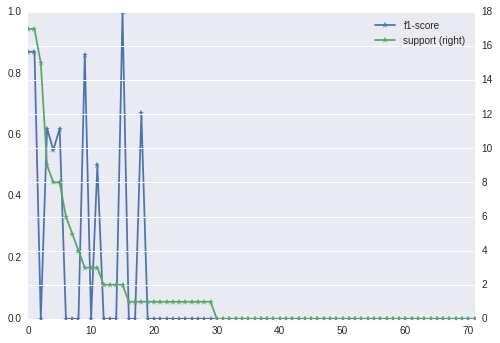

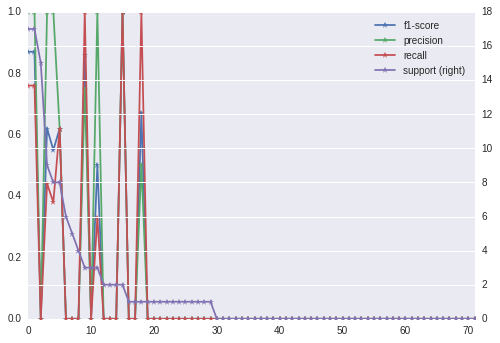

In [51]:
y_pred = y_pred_prob > 0.5
print(classification_report(y_true, y_pred, target_names=clf.get_tag_names()))
print('hamming loss:', hamming_loss(y_true, y_pred))
print('LRAP:', label_ranking_average_precision_score(y_true, y_pred))
clf_rep_df = get_classification_report_df(y_true, y_pred, target_names=clf.get_tag_names())
clf_rep_df.sort_values(by='support', ascending=False, inplace=True)
clf_rep_df.index = range(len(clf_rep_df))
clf_rep_df.plot(y=['f1-score', 'support'], secondary_y=['support'], style='*-')
plt.show()
clf_rep_df.plot(y=['f1-score', 'precision', 'recall', 'support'], secondary_y=['support'], style='*-')
plt.show()